In [24]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [9]:
# View all of the classes that automap found
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [15]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).first()[0]
recent_date

'2017-08-23'

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Starting from the most recent data point in the database. 
latest_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
start_date = latest_date - dt.timedelta(days=365)
# print(start_date)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, 
       func.sum(Measurement.prcp)]
prcp = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()
# pprint(prcp)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp, columns = ["Measurement_Date", "Precipitation"])
# Sort the dataframe by date
prcp_df.set_index("Measurement_Date", inplace=True)
prcp_df.head(10)

,Precipitation
Measurement_Date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10
2016-08-29,1.46
2016-08-30,0.07
2016-08-31,3.18
2016-09-01,0.03


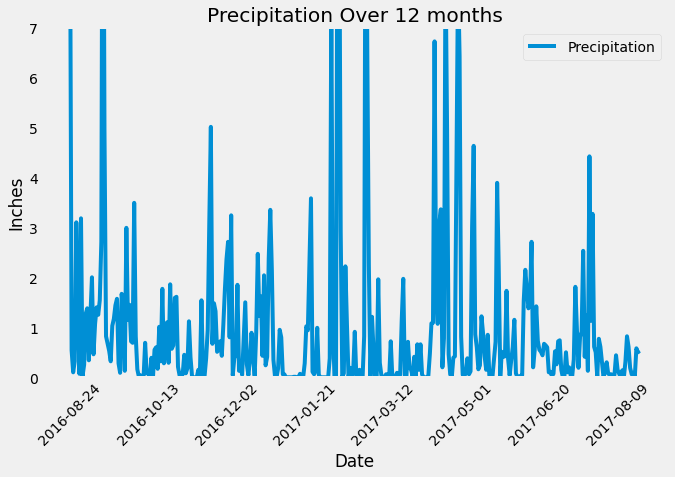

In [34]:
# Use Pandas Plotting with Matplotlib to plot the data
plot = prcp_df.plot(figsize=(10,6), ylim=(0,7), title = "Precipitation Over 12 months", rot=45)
plot.set_ylabel("Inches")
plot.set_xlabel("Date")
plot.grid()
plt.savefig("Images/precipitation.png")
plt.show()

In [37]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


# Exploratory Station Analysis

In [44]:
# Design a query to calculate the total number stations in the dataset
total = session.query(func.count(func.distinct(Measurement.station))).first()[0]
total

9

In [46]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.id))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.id).desc()).all()
# List the stations and the counts in descending order.
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [47]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)]
station_temp_summary = session.query(*sel).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for parameter in station_temp_summary:
    print(parameter)

('USC00519281', 54.0, 85.0, 71.66378066378067)


In [49]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, 
       Measurement.tobs]
station_TOBS = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date, Measurement.station == 'USC00519281').\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

# Create a datafrem containing the results of this query
temps_df = pd.DataFrame(station_TOBS, columns=['Measurement_Date', 'Temperature'])
temps_df.head()

,Measurement_Date,Temperature
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


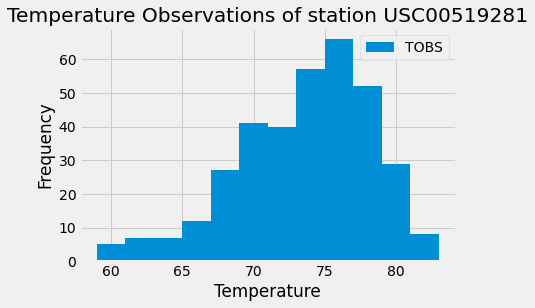

In [55]:
# plot histogram
plt.hist(temps_df['Temperature'],bins=12, density=False, label="TOBS")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.title("Temperature Observations of station USC00519281")
plt.figsize=(10,7)
plt.savefig('Images/station-histogram.png',bbox_inches='tight')
plt.show()

# Close session

In [54]:
# Close Session
session.close()